In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import seaborn as sns

from os.path import join

plt.style.use(["seaborn", "thesis"])

In [3]:
plt.rc("figure", figsize=(8,4))

# Fetch Dataset 

In [6]:
from SCFInitialGuess.utilities.dataset import ScreenedData

target = "P"

data = ScreenedData(r_max=10)

data.include(data_path = "../../dataset/MethanT/", postfix = "MethanT", target=target)
data.include(data_path = "../../dataset/MethanT2/", postfix = "MethanT2", target=target)
data.include(data_path = "../../dataset/MethanT3/", postfix = "MethanT3", target=target)
data.include(data_path = "../../dataset/MethanT4/", postfix = "MethanT4", target=target)

data.include(data_path = "../../dataset/EthanT/",  postfix = "EthanT", target=target)
data.include(data_path = "../../dataset/EthanT2/", postfix = "EthanT2", target=target)
data.include(data_path = "../../dataset/EthanT3/", postfix = "EthanT3", target=target)
data.include(data_path = "../../dataset/EthanT4/",  postfix = "EthanT4", target=target)
data.include(data_path = "../../dataset/EthanT5/",  postfix = "EthanT5", target=target)
data.include(data_path = "../../dataset/EthanT6/",  postfix = "EthanT6", target=target)

data.include(data_path = "../../dataset/EthenT/",  postfix = "EthenT", target=target)
data.include(data_path = "../../dataset/EthenT2/", postfix = "EthenT2", target=target)
data.include(data_path = "../../dataset/EthenT3/", postfix = "EthenT3", target=target)
data.include(data_path = "../../dataset/EthenT4/",  postfix = "EthenT4", target=target)
data.include(data_path = "../../dataset/EthenT5/",  postfix = "EthenT5", target=target)
data.include(data_path = "../../dataset/EthenT6/",  postfix = "EthenT6", target=target)


data.include(data_path = "../../dataset/EthinT/",  postfix = "EthinT", target=target)
data.include(data_path = "../../dataset/EthinT2/", postfix = "EthinT2", target=target)
data.include(data_path = "../../dataset/EthinT3/", postfix = "EthinT3", target=target)

#data.include(data_path = "../../dataset/QM9/", postfix = "QM9-300")

In [7]:
basis = "6-311++g**"
model_path="../../models/DescriptorC/" + target + "/"

# Descriptor 

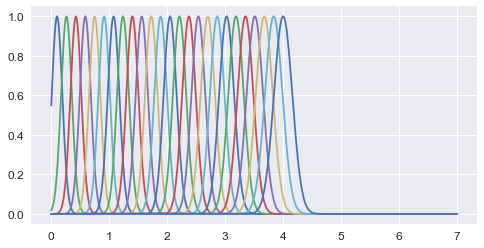

In [285]:
from SCFInitialGuess.descriptors.models import make_uniform 
from SCFInitialGuess.descriptors.utilities import plot_normal_model

        
#model = make_uniform(n=400, R_c=5, eta_min=800, eta_max=2000)

# origin 20
"""
model = (
    [0.0] * 20,
    np.logspace(0.5, -1, 20)
)
"""


# custom-c
#R_c = 7
#n = 10
#model = (
#        np.linspace(1.0, R_c*0.8, n),
#        np.linspace(10, 1, n),
#    )

# unif -5
#model = make_uniform(5, 5, eta_max=10, eta_min=1)

#unif-25
model = make_uniform(25, 5, eta_max=60, eta_min=20)

#model = make_uniform(n=50, R_c=5, eta_min=100, eta_max=30)
plot_normal_model(model, np.linspace(0, 7, 500))

In [286]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset
from SCFInitialGuess.descriptors.high_level import AtomicNumberWeighted
from SCFInitialGuess.descriptors.cutoffs import BehlerCutoff1
from SCFInitialGuess.descriptors.models import RADIAL_GAUSSIAN_MODELS, make_uniform
from SCFInitialGuess.descriptors.coordinate_descriptors import \
    Gaussians, SPHAngularDescriptor
import pickle

descriptor = AtomicNumberWeighted(
    Gaussians(*model),
    SPHAngularDescriptor(4),
    BehlerCutoff1(5)
)

pickle.dump(descriptor, open(model_path + "descriptor.dump", "wb"))
    
descriptor.radial_descriptor.number_of_descriptors, descriptor.angular_descriptor.number_of_descriptors, descriptor.number_of_descriptors

(25, 50, 75)

In [287]:
from SCFInitialGuess.utilities.dataset import make_center_block_dataset
index=200
f = lambda x: x#(x[0][:index], x[0][index:(2*index)], x[2])

dataset_C = make_center_block_dataset(
    descriptor,
    data.molecules,
    data.T,
    "C"
)

np.save(model_path + "normalisation.npy", (dataset_C.x_mean, dataset_C.x_std))


In [288]:
np.mean(dataset_C.testing[1][0])

0.016298800569369148

In [289]:
len(dataset_C.training[0]), len(dataset_C.validation[0]), len(dataset_C.testing[0]), 

(12530, 3144, 3943)

In [290]:
from SCFInitialGuess.utilities.dataset import AbstractDataset

x_train = AbstractDataset.denormalize(dataset_C.training[0], dataset_C.x_mean, dataset_C.x_std)
y_train = dataset_C.training[1]
np.mean(x_train[0] - x_train[-1])

-0.031716471140777275

## Autocorrelation 

In [291]:
dataset_C.training[0].shape

(12530, 75)

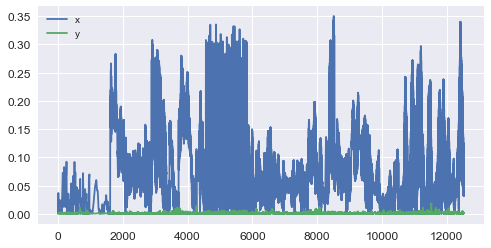

In [292]:

plt.plot(abs(np.mean(x_train[0] - x_train[1:], 1)), label="x")
plt.plot(abs(np.mean(y_train[0] - y_train[1:], 1)), label="y")

plt.legend()

## Variance

In [293]:
np.var(x_train, 0).shape

(75,)

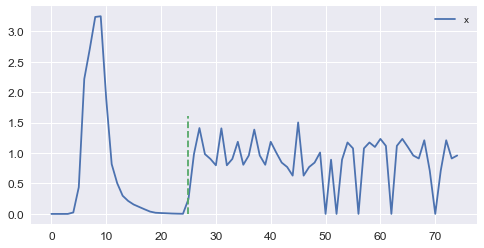

In [294]:
offset=0
plt.plot(np.var(x_train, 0)[offset:], label="x")
plt.plot([descriptor.radial_descriptor.number_of_descriptors - offset]*2, [1e-3, 1.6], "--")

plt.legend()

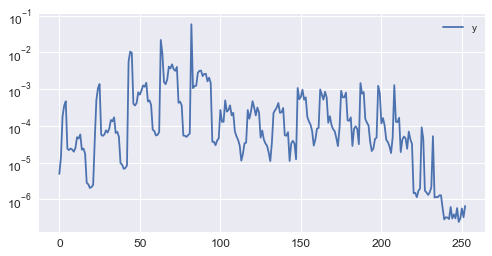

In [270]:
plt.semilogy(np.var(y_train, 0), label="y")
plt.legend()

# Average 

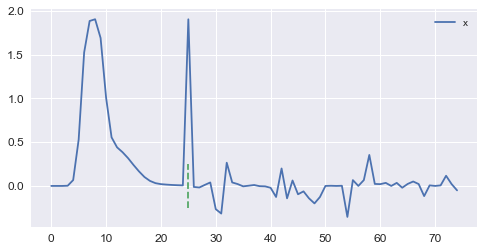

In [295]:
plt.plot(np.mean(x_train, 0), label="x")
plt.plot([descriptor.radial_descriptor.number_of_descriptors]*2, [-0.25, 0.25], "--")

plt.legend()

# Network Stuff 

In [296]:
#keras.backend.clear_session()

#activation = "elu"
#learning_rate = 1e-5

intializer = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.01)

def make_model(
        structure, 
        input_dim, 
        output_dim,
        activation="elu", 
        learning_rate=1e-3
    ):

    model = keras.Sequential()

    # input layer
    model.add(keras.layers.Dense(
        structure[0], 
        activation=activation, 
        input_dim=input_dim, 
        kernel_initializer=intializer
    ))

    for layer in structure[1:]:
        model.add(keras.layers.Dense(
            layer, 
            activation=activation, 
            #kernel_initializer=intializer, 
            #bias_initializer='zeros',
            kernel_regularizer=keras.regularizers.l2(1e-4)
        ))

    #output
    model.add(keras.layers.Dense(output_dim))

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate), 
        loss='MSE', 
        metrics=['mse']
    )
    
    return model



In [301]:
path = model_path

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_mean_squared_error", 
    min_delta=1e-8, 
    patience=20, 
    verbose=1
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_mean_squared_error', 
    factor=0.1, 
    patience=3, 
    verbose=1, 
    mode='auto', 
    min_delta=1e-6, 
    cooldown=2, 
    min_lr=1e-10
)


epochs = 1000


def train_model(model, dataset, filepath, learning_rate=1e-4, log_dir="./logs"):

    
    tensorboard = keras.callbacks.TensorBoard(
        log_dir=log_dir, 
        histogram_freq=0, 
        batch_size=32, 
        #update_freq='epoch'
    )
    
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, 
        monitor='val_mean_squared_error', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=False, 
        mode='auto', 
        period=1
    )
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    train, validation = [], []
    while True:
        keras.backend.set_value(model.optimizer.lr, learning_rate)
            
        history = model.fit(
            x = dataset.training[0],
            y = dataset.training[1],
            epochs=epochs,
            shuffle=True,
            validation_data=dataset.validation, 
            verbose=1, 
            callbacks=[
                early_stopping, 
                reduce_lr,
                checkpoint,
                tensorboard
            ]
        )
            
        
        #error.append(model.evaluate(
        #    dataset.testing[0], 
        #    dataset.testing[1], 
        #    verbose=1
        #)[1])
    
    return error
    

# Actucal training 

In [302]:
len(dataset_C.training[0]), len(dataset_C.validation[0]), len(dataset_C.testing[0]), 

(12530, 3144, 3943)

In [303]:
from SCFInitialGuess.utilities.constants import number_of_basis_functions as N_BASIS


species = "C"

dim_C = N_BASIS[basis][species]
dim_C_triu = dim_C * (dim_C + 1) // 2


In [304]:
descriptor.number_of_descriptors, dim_C_triu

(75, 253)

In [305]:
structure_C = [100, 200]

In [306]:
keras.backend.clear_session()

In [307]:
model_C = make_model(
    structure=structure_C,
    input_dim=descriptor.number_of_descriptors,
    output_dim=dim_C_triu,
    
)

model_C.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               7600      
_________________________________________________________________
dense_1 (Dense)              (None, 200)               20200     
_________________________________________________________________
dense_2 (Dense)              (None, 253)               50853     
Total params: 78,653
Trainable params: 78,653
Non-trainable params: 0
_________________________________________________________________


In [308]:
i =0
name_C = "C_" + target + ".h5"
name = "F/500-10"

Train on 12530 samples, validate on 3144 samples
Epoch 1/1000
12530/12530 [==============================] - 1s 87us/step - loss: 0.0134 - mean_squared_error: 0.0035 - val_loss: 0.0080 - val_mean_squared_error: 9.9920e-04

Epoch 00001: val_mean_squared_error improved from inf to 0.00100, saving model to ../../models/DescriptorC/P/C_P.h5
Epoch 2/1000
12530/12530 [==============================] - 1s 73us/step - loss: 0.0056 - mean_squared_error: 6.8900e-04 - val_loss: 0.0040 - val_mean_squared_error: 8.3847e-04

Epoch 00002: val_mean_squared_error improved from 0.00100 to 0.00084, saving model to ../../models/DescriptorC/P/C_P.h5
Epoch 3/1000
12530/12530 [==============================] - 1s 75us/step - loss: 0.0028 - mean_squared_error: 6.2617e-04 - val_loss: 0.0021 - val_mean_squared_error: 8.0686e-04

Epoch 00003: val_mean_squared_error improved from 0.00084 to 0.00081, saving model to ../../models/DescriptorC/P/C_P.h5
Epoch 4/1000
12530/12530 [==============================] - 1s 77

12530/12530 [==============================] - 1s 80us/step - loss: 5.0478e-04 - mean_squared_error: 4.8569e-04 - val_loss: 7.1355e-04 - val_mean_squared_error: 6.9404e-04

Epoch 00029: val_mean_squared_error did not improve from 0.00069
Epoch 30/1000
12530/12530 [==============================] - 1s 84us/step - loss: 5.0256e-04 - mean_squared_error: 4.8339e-04 - val_loss: 6.9783e-04 - val_mean_squared_error: 6.7828e-04

Epoch 00030: val_mean_squared_error improved from 0.00069 to 0.00068, saving model to ../../models/DescriptorC/P/C_P.h5
Epoch 31/1000
12530/12530 [==============================] - 1s 84us/step - loss: 4.9873e-04 - mean_squared_error: 4.7910e-04 - val_loss: 7.0556e-04 - val_mean_squared_error: 6.8618e-04

Epoch 00031: val_mean_squared_error did not improve from 0.00068
Epoch 32/1000
12530/12530 [==============================] - 1s 104us/step - loss: 4.9648e-04 - mean_squared_error: 4.7703e-04 - val_loss: 7.0698e-04 - val_mean_squared_error: 6.8750e-04

Epoch 00032: va

12530/12530 [==============================] - 2s 147us/step - loss: 4.7871e-04 - mean_squared_error: 4.5878e-04 - val_loss: 6.9458e-04 - val_mean_squared_error: 6.7466e-04

Epoch 00057: ReduceLROnPlateau reducing learning rate to 1e-10.

Epoch 00057: val_mean_squared_error did not improve from 0.00067
Epoch 58/1000
12530/12530 [==============================] - 2s 139us/step - loss: 4.7871e-04 - mean_squared_error: 4.5878e-04 - val_loss: 6.9458e-04 - val_mean_squared_error: 6.7466e-04

Epoch 00058: val_mean_squared_error did not improve from 0.00067
Epoch 59/1000
12530/12530 [==============================] - 2s 146us/step - loss: 4.7871e-04 - mean_squared_error: 4.5878e-04 - val_loss: 6.9458e-04 - val_mean_squared_error: 6.7466e-04

Epoch 00059: val_mean_squared_error did not improve from 0.00067
Epoch 60/1000
12530/12530 [==============================] - 2s 143us/step - loss: 4.7871e-04 - mean_squared_error: 4.5878e-04 - val_loss: 6.9458e-04 - val_mean_squared_error: 6.7466e-04

Ep

12530/12530 [==============================] - 2s 146us/step - loss: 4.4278e-04 - mean_squared_error: 4.2135e-04 - val_loss: 6.7082e-04 - val_mean_squared_error: 6.4940e-04

Epoch 00022: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00022: val_mean_squared_error did not improve from 0.00065
Epoch 23/1000
12530/12530 [==============================] - 2s 124us/step - loss: 4.4257e-04 - mean_squared_error: 4.2115e-04 - val_loss: 6.7082e-04 - val_mean_squared_error: 6.4940e-04

Epoch 00023: val_mean_squared_error did not improve from 0.00065
Epoch 24/1000
12530/12530 [==============================] - 2s 124us/step - loss: 4.4256e-04 - mean_squared_error: 4.2114e-04 - val_loss: 6.7083e-04 - val_mean_squared_error: 6.4941e-04

Epoch 00024: val_mean_squared_error did not improve from 0.00065
Epoch 25/1000
12530/12530 [==============================] - 2s 157us/step - loss: 4.4256e-04 - mean_squared_error: 4.2114e-04 - val_loss: 6.7083e-04 - val_mean_squared_error

12530/12530 [==============================] - 2s 158us/step - loss: 4.3135e-04 - mean_squared_error: 4.0881e-04 - val_loss: 6.5679e-04 - val_mean_squared_error: 6.3463e-04

Epoch 00013: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00013: val_mean_squared_error did not improve from 0.00063
Epoch 14/1000
12530/12530 [==============================] - 3s 211us/step - loss: 4.1860e-04 - mean_squared_error: 3.9646e-04 - val_loss: 6.5088e-04 - val_mean_squared_error: 6.2859e-04

Epoch 00014: val_mean_squared_error improved from 0.00063 to 0.00063, saving model to ../../models/DescriptorC/P/C_P.h5
Epoch 15/1000
12530/12530 [==============================] - 2s 182us/step - loss: 4.1685e-04 - mean_squared_error: 3.9458e-04 - val_loss: 6.4931e-04 - val_mean_squared_error: 6.2700e-04

Epoch 00015: val_mean_squared_error improved from 0.00063 to 0.00063, saving model to ../../models/DescriptorC/P/C_P.h5
Epoch 16/1000
12530/12530 [==============================] - 2s 

12530/12530 [==============================] - 5s 399us/step - loss: 4.1312e-04 - mean_squared_error: 3.9057e-04 - val_loss: 6.4719e-04 - val_mean_squared_error: 6.2464e-04

Epoch 00042: val_mean_squared_error did not improve from 0.00062
Epoch 00042: early stopping
Train on 12530 samples, validate on 3144 samples
Epoch 1/1000
12530/12530 [==============================] - 4s 284us/step - loss: 4.2688e-04 - mean_squared_error: 4.0443e-04 - val_loss: 6.4996e-04 - val_mean_squared_error: 6.2749e-04

Epoch 00001: val_mean_squared_error did not improve from 0.00062
Epoch 2/1000
12530/12530 [==============================] - 3s 250us/step - loss: 4.2655e-04 - mean_squared_error: 4.0397e-04 - val_loss: 6.5064e-04 - val_mean_squared_error: 6.2830e-04

Epoch 00002: val_mean_squared_error did not improve from 0.00062
Epoch 3/1000
12530/12530 [==============================] - 3s 227us/step - loss: 4.2307e-04 - mean_squared_error: 4.0070e-04 - val_loss: 6.5067e-04 - val_mean_squared_error: 6.280


Epoch 00003: val_mean_squared_error did not improve from 0.00062
Epoch 4/1000
12530/12530 [==============================] - 4s 289us/step - loss: 4.1531e-04 - mean_squared_error: 3.9268e-04 - val_loss: 6.4453e-04 - val_mean_squared_error: 6.2210e-04

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00004: val_mean_squared_error did not improve from 0.00062
Epoch 5/1000
12530/12530 [==============================] - 3s 259us/step - loss: 4.0184e-04 - mean_squared_error: 3.7944e-04 - val_loss: 6.3525e-04 - val_mean_squared_error: 6.1284e-04

Epoch 00005: val_mean_squared_error improved from 0.00062 to 0.00061, saving model to ../../models/DescriptorC/P/C_P.h5
Epoch 6/1000
12530/12530 [==============================] - 4s 306us/step - loss: 4.0016e-04 - mean_squared_error: 3.7770e-04 - val_loss: 6.3503e-04 - val_mean_squared_error: 6.1249e-04

Epoch 00006: val_mean_squared_error improved from 0.00061 to 0.00061, saving model to ../../models/Descript

Epoch 1/1000
12530/12530 [==============================] - 4s 325us/step - loss: 4.1203e-04 - mean_squared_error: 3.8928e-04 - val_loss: 6.5168e-04 - val_mean_squared_error: 6.2926e-04

Epoch 00001: val_mean_squared_error did not improve from 0.00061
Epoch 2/1000
12530/12530 [==============================] - 4s 326us/step - loss: 4.1256e-04 - mean_squared_error: 3.9009e-04 - val_loss: 6.3374e-04 - val_mean_squared_error: 6.1120e-04

Epoch 00002: val_mean_squared_error did not improve from 0.00061
Epoch 3/1000
12530/12530 [==============================] - 4s 280us/step - loss: 4.1029e-04 - mean_squared_error: 3.8774e-04 - val_loss: 6.4602e-04 - val_mean_squared_error: 6.2371e-04

Epoch 00003: val_mean_squared_error did not improve from 0.00061
Epoch 4/1000
12530/12530 [==============================] - 3s 266us/step - loss: 4.0818e-04 - mean_squared_error: 3.8571e-04 - val_loss: 6.4054e-04 - val_mean_squared_error: 6.1787e-04

Epoch 00004: val_mean_squared_error did not improve from 

12530/12530 [==============================] - 4s 285us/step - loss: 3.9957e-04 - mean_squared_error: 3.7698e-04 - val_loss: 6.2959e-04 - val_mean_squared_error: 6.0743e-04

Epoch 00005: val_mean_squared_error did not improve from 0.00060
Epoch 6/1000
12530/12530 [==============================] - 3s 223us/step - loss: 3.9773e-04 - mean_squared_error: 3.7522e-04 - val_loss: 6.5534e-04 - val_mean_squared_error: 6.3279e-04

Epoch 00006: val_mean_squared_error did not improve from 0.00060
Epoch 7/1000
12530/12530 [==============================] - 3s 218us/step - loss: 3.9799e-04 - mean_squared_error: 3.7548e-04 - val_loss: 6.3532e-04 - val_mean_squared_error: 6.1269e-04

Epoch 00007: val_mean_squared_error did not improve from 0.00060
Epoch 8/1000
12530/12530 [==============================] - 2s 177us/step - loss: 3.9577e-04 - mean_squared_error: 3.7335e-04 - val_loss: 6.3418e-04 - val_mean_squared_error: 6.1126e-04

Epoch 00008: ReduceLROnPlateau reducing learning rate to 9.99999974737


Epoch 00001: val_mean_squared_error did not improve from 0.00059
Epoch 2/1000
12530/12530 [==============================] - 3s 241us/step - loss: 3.9385e-04 - mean_squared_error: 3.7141e-04 - val_loss: 6.3385e-04 - val_mean_squared_error: 6.1144e-04

Epoch 00002: val_mean_squared_error did not improve from 0.00059
Epoch 3/1000
12530/12530 [==============================] - 3s 221us/step - loss: 3.9109e-04 - mean_squared_error: 3.6851e-04 - val_loss: 6.2867e-04 - val_mean_squared_error: 6.0626e-04

Epoch 00003: val_mean_squared_error did not improve from 0.00059
Epoch 4/1000
12530/12530 [==============================] - 2s 163us/step - loss: 3.9155e-04 - mean_squared_error: 3.6918e-04 - val_loss: 6.2556e-04 - val_mean_squared_error: 6.0297e-04

Epoch 00004: val_mean_squared_error did not improve from 0.00059
Epoch 5/1000
12530/12530 [==============================] - 2s 188us/step - loss: 3.9080e-04 - mean_squared_error: 3.6816e-04 - val_loss: 6.3187e-04 - val_mean_squared_error: 6.0

12530/12530 [==============================] - 2s 168us/step - loss: 3.6504e-04 - mean_squared_error: 3.4256e-04 - val_loss: 6.1146e-04 - val_mean_squared_error: 5.8897e-04

Epoch 00031: val_mean_squared_error did not improve from 0.00059
Epoch 32/1000
12530/12530 [==============================] - 2s 195us/step - loss: 3.6504e-04 - mean_squared_error: 3.4256e-04 - val_loss: 6.1146e-04 - val_mean_squared_error: 5.8897e-04

Epoch 00032: val_mean_squared_error did not improve from 0.00059
Epoch 33/1000
12530/12530 [==============================] - 3s 221us/step - loss: 3.6504e-04 - mean_squared_error: 3.4256e-04 - val_loss: 6.1146e-04 - val_mean_squared_error: 5.8897e-04

Epoch 00033: val_mean_squared_error did not improve from 0.00059
Epoch 34/1000
12530/12530 [==============================] - 4s 294us/step - loss: 3.6504e-04 - mean_squared_error: 3.4256e-04 - val_loss: 6.1146e-04 - val_mean_squared_error: 5.8897e-04

Epoch 00034: ReduceLROnPlateau reducing learning rate to 1e-10.

Ep

12530/12530 [==============================] - 3s 255us/step - loss: 3.5844e-04 - mean_squared_error: 3.3599e-04 - val_loss: 6.0973e-04 - val_mean_squared_error: 5.8729e-04

Epoch 00020: val_mean_squared_error did not improve from 0.00059
Epoch 21/1000
12530/12530 [==============================] - 3s 214us/step - loss: 3.5844e-04 - mean_squared_error: 3.3599e-04 - val_loss: 6.0973e-04 - val_mean_squared_error: 5.8728e-04

Epoch 00021: val_mean_squared_error did not improve from 0.00059
Epoch 22/1000
12530/12530 [==============================] - 2s 177us/step - loss: 3.5844e-04 - mean_squared_error: 3.3599e-04 - val_loss: 6.0973e-04 - val_mean_squared_error: 5.8728e-04

Epoch 00022: val_mean_squared_error did not improve from 0.00059
Epoch 23/1000
12530/12530 [==============================] - 2s 193us/step - loss: 3.5844e-04 - mean_squared_error: 3.3599e-04 - val_loss: 6.0972e-04 - val_mean_squared_error: 5.8728e-04

Epoch 00023: ReduceLROnPlateau reducing learning rate to 9.99999993


Epoch 00017: val_mean_squared_error did not improve from 0.00059
Epoch 18/1000
12530/12530 [==============================] - 3s 234us/step - loss: 3.5370e-04 - mean_squared_error: 3.3135e-04 - val_loss: 6.0827e-04 - val_mean_squared_error: 5.8592e-04

Epoch 00018: val_mean_squared_error did not improve from 0.00059
Epoch 19/1000
12530/12530 [==============================] - 4s 281us/step - loss: 3.5369e-04 - mean_squared_error: 3.3134e-04 - val_loss: 6.0829e-04 - val_mean_squared_error: 5.8594e-04

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.

Epoch 00019: val_mean_squared_error did not improve from 0.00059
Epoch 20/1000
12530/12530 [==============================] - 3s 231us/step - loss: 3.5366e-04 - mean_squared_error: 3.3131e-04 - val_loss: 6.0829e-04 - val_mean_squared_error: 5.8594e-04

Epoch 00020: val_mean_squared_error did not improve from 0.00059
Epoch 21/1000
12530/12530 [==============================] - 3s 277us/step - loss: 3.5366e-04


Epoch 00013: val_mean_squared_error did not improve from 0.00058
Epoch 14/1000
12530/12530 [==============================] - 3s 273us/step - loss: 3.4977e-04 - mean_squared_error: 3.2756e-04 - val_loss: 6.0738e-04 - val_mean_squared_error: 5.8518e-04

Epoch 00014: val_mean_squared_error did not improve from 0.00058
Epoch 15/1000
12530/12530 [==============================] - 3s 219us/step - loss: 3.4976e-04 - mean_squared_error: 3.2756e-04 - val_loss: 6.0738e-04 - val_mean_squared_error: 5.8517e-04

Epoch 00015: val_mean_squared_error did not improve from 0.00058
Epoch 16/1000
12530/12530 [==============================] - 4s 296us/step - loss: 3.4976e-04 - mean_squared_error: 3.2755e-04 - val_loss: 6.0738e-04 - val_mean_squared_error: 5.8517e-04

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.

Epoch 00016: val_mean_squared_error did not improve from 0.00058
Epoch 17/1000
12530/12530 [==============================] - 4s 297us/step - loss: 3.4973e-04

12530/12530 [==============================] - 4s 296us/step - loss: 3.4312e-04 - mean_squared_error: 3.2106e-04 - val_loss: 6.0673e-04 - val_mean_squared_error: 5.8467e-04

Epoch 00019: val_mean_squared_error did not improve from 0.00058
Epoch 20/1000
12530/12530 [==============================] - 3s 240us/step - loss: 3.4312e-04 - mean_squared_error: 3.2105e-04 - val_loss: 6.0674e-04 - val_mean_squared_error: 5.8468e-04

Epoch 00020: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.

Epoch 00020: val_mean_squared_error did not improve from 0.00058
Epoch 21/1000
12530/12530 [==============================] - 4s 300us/step - loss: 3.4308e-04 - mean_squared_error: 3.2102e-04 - val_loss: 6.0675e-04 - val_mean_squared_error: 5.8468e-04

Epoch 00021: val_mean_squared_error did not improve from 0.00058
Epoch 22/1000
12530/12530 [==============================] - 3s 252us/step - loss: 3.4308e-04 - mean_squared_error: 3.2102e-04 - val_loss: 6.0675e-04 - val_mean_squared_erro

12530/12530 [==============================] - 3s 278us/step - loss: 3.3976e-04 - mean_squared_error: 3.1788e-04 - val_loss: 6.0646e-04 - val_mean_squared_error: 5.8458e-04

Epoch 00013: val_mean_squared_error did not improve from 0.00058
Epoch 14/1000
12530/12530 [==============================] - 4s 338us/step - loss: 3.3975e-04 - mean_squared_error: 3.1787e-04 - val_loss: 6.0643e-04 - val_mean_squared_error: 5.8455e-04

Epoch 00014: val_mean_squared_error did not improve from 0.00058
Epoch 15/1000
12530/12530 [==============================] - 4s 345us/step - loss: 3.3975e-04 - mean_squared_error: 3.1787e-04 - val_loss: 6.0641e-04 - val_mean_squared_error: 5.8453e-04

Epoch 00015: val_mean_squared_error did not improve from 0.00058
Epoch 16/1000
12530/12530 [==============================] - 4s 325us/step - loss: 3.3974e-04 - mean_squared_error: 3.1786e-04 - val_loss: 6.0641e-04 - val_mean_squared_error: 5.8453e-04

Epoch 00016: ReduceLROnPlateau reducing learning rate to 1.00000001

12530/12530 [==============================] - 8s 631us/step - loss: 3.3474e-04 - mean_squared_error: 3.1290e-04 - val_loss: 6.0698e-04 - val_mean_squared_error: 5.8514e-04

Epoch 00018: val_mean_squared_error did not improve from 0.00058
Epoch 19/1000
12530/12530 [==============================] - 9s 682us/step - loss: 3.3474e-04 - mean_squared_error: 3.1290e-04 - val_loss: 6.0700e-04 - val_mean_squared_error: 5.8516e-04

Epoch 00019: ReduceLROnPlateau reducing learning rate to 1.0000000116860975e-08.

Epoch 00019: val_mean_squared_error did not improve from 0.00058
Epoch 20/1000
12530/12530 [==============================] - 6s 512us/step - loss: 3.3470e-04 - mean_squared_error: 3.1287e-04 - val_loss: 6.0700e-04 - val_mean_squared_error: 5.8516e-04

Epoch 00020: val_mean_squared_error did not improve from 0.00058
Epoch 21/1000
12530/12530 [==============================] - 5s 391us/step - loss: 3.3470e-04 - mean_squared_error: 3.1287e-04 - val_loss: 6.0700e-04 - val_mean_squared_erro

12530/12530 [==============================] - 3s 245us/step - loss: 3.3050e-04 - mean_squared_error: 3.0901e-04 - val_loss: 6.0678e-04 - val_mean_squared_error: 5.8528e-04

Epoch 00015: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00015: val_mean_squared_error did not improve from 0.00058
Epoch 16/1000
12530/12530 [==============================] - 4s 308us/step - loss: 3.3020e-04 - mean_squared_error: 3.0870e-04 - val_loss: 6.0681e-04 - val_mean_squared_error: 5.8531e-04

Epoch 00016: val_mean_squared_error did not improve from 0.00058
Epoch 17/1000
12530/12530 [==============================] - 4s 339us/step - loss: 3.3020e-04 - mean_squared_error: 3.0870e-04 - val_loss: 6.0685e-04 - val_mean_squared_error: 5.8535e-04

Epoch 00017: val_mean_squared_error did not improve from 0.00058
Epoch 18/1000
12530/12530 [==============================] - 4s 335us/step - loss: 3.3019e-04 - mean_squared_error: 3.0869e-04 - val_loss: 6.0686e-04 - val_mean_squared_error

12530/12530 [==============================] - 4s 300us/step - loss: 3.2470e-04 - mean_squared_error: 3.0335e-04 - val_loss: 6.0919e-04 - val_mean_squared_error: 5.8784e-04

Epoch 00017: val_mean_squared_error did not improve from 0.00058
Epoch 18/1000
12530/12530 [==============================] - 4s 309us/step - loss: 3.2463e-04 - mean_squared_error: 3.0329e-04 - val_loss: 6.0894e-04 - val_mean_squared_error: 5.8759e-04

Epoch 00018: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00018: val_mean_squared_error did not improve from 0.00058
Epoch 19/1000
12530/12530 [==============================] - 4s 289us/step - loss: 3.2435e-04 - mean_squared_error: 3.0300e-04 - val_loss: 6.0897e-04 - val_mean_squared_error: 5.8762e-04

Epoch 00019: val_mean_squared_error did not improve from 0.00058
Epoch 20/1000
12530/12530 [==============================] - 4s 317us/step - loss: 3.2434e-04 - mean_squared_error: 3.0299e-04 - val_loss: 6.0899e-04 - val_mean_squared_error

12530/12530 [==============================] - 4s 324us/step - loss: 3.2205e-04 - mean_squared_error: 3.0077e-04 - val_loss: 6.0923e-04 - val_mean_squared_error: 5.8795e-04

Epoch 00012: val_mean_squared_error did not improve from 0.00058
Epoch 13/1000
12530/12530 [==============================] - 4s 336us/step - loss: 3.2163e-04 - mean_squared_error: 3.0035e-04 - val_loss: 6.0935e-04 - val_mean_squared_error: 5.8807e-04

Epoch 00013: val_mean_squared_error did not improve from 0.00058
Epoch 14/1000
12530/12530 [==============================] - 6s 440us/step - loss: 3.2154e-04 - mean_squared_error: 3.0026e-04 - val_loss: 6.0944e-04 - val_mean_squared_error: 5.8815e-04

Epoch 00014: val_mean_squared_error did not improve from 0.00058
Epoch 15/1000
12530/12530 [==============================] - 4s 341us/step - loss: 3.2151e-04 - mean_squared_error: 3.0023e-04 - val_loss: 6.0952e-04 - val_mean_squared_error: 5.8824e-04

Epoch 00015: ReduceLROnPlateau reducing learning rate to 9.99999997

12530/12530 [==============================] - 6s 508us/step - loss: 3.1909e-04 - mean_squared_error: 2.9803e-04 - val_loss: 6.0994e-04 - val_mean_squared_error: 5.8888e-04

Epoch 00014: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00014: val_mean_squared_error did not improve from 0.00058
Epoch 15/1000
12530/12530 [==============================] - 6s 454us/step - loss: 3.1880e-04 - mean_squared_error: 2.9774e-04 - val_loss: 6.0992e-04 - val_mean_squared_error: 5.8886e-04

Epoch 00015: val_mean_squared_error did not improve from 0.00058
Epoch 16/1000
12530/12530 [==============================] - 8s 600us/step - loss: 3.1879e-04 - mean_squared_error: 2.9774e-04 - val_loss: 6.0989e-04 - val_mean_squared_error: 5.8884e-04

Epoch 00016: val_mean_squared_error did not improve from 0.00058
Epoch 17/1000
12530/12530 [==============================] - 6s 490us/step - loss: 3.1879e-04 - mean_squared_error: 2.9773e-04 - val_loss: 6.0987e-04 - val_mean_squared_error

12530/12530 [==============================] - 9s 712us/step - loss: 3.1647e-04 - mean_squared_error: 2.9561e-04 - val_loss: 6.0948e-04 - val_mean_squared_error: 5.8863e-04

Epoch 00013: val_mean_squared_error did not improve from 0.00058
Epoch 14/1000
12530/12530 [==============================] - 9s 740us/step - loss: 3.1640e-04 - mean_squared_error: 2.9555e-04 - val_loss: 6.0952e-04 - val_mean_squared_error: 5.8866e-04

Epoch 00014: val_mean_squared_error did not improve from 0.00058
Epoch 15/1000
12530/12530 [==============================] - 8s 651us/step - loss: 3.1635e-04 - mean_squared_error: 2.9550e-04 - val_loss: 6.0961e-04 - val_mean_squared_error: 5.8875e-04

Epoch 00015: ReduceLROnPlateau reducing learning rate to 9.999999974752428e-08.

Epoch 00015: val_mean_squared_error did not improve from 0.00058
Epoch 16/1000
12530/12530 [==============================] - 7s 543us/step - loss: 3.1605e-04 - mean_squared_error: 2.9520e-04 - val_loss: 6.0964e-04 - val_mean_squared_error

12530/12530 [==============================] - 6s 452us/step - loss: 3.1370e-04 - mean_squared_error: 2.9298e-04 - val_loss: 6.1146e-04 - val_mean_squared_error: 5.9074e-04

Epoch 00012: val_mean_squared_error did not improve from 0.00058
Epoch 13/1000
12530/12530 [==============================] - 5s 401us/step - loss: 3.1362e-04 - mean_squared_error: 2.9289e-04 - val_loss: 6.1084e-04 - val_mean_squared_error: 5.9012e-04

Epoch 00013: val_mean_squared_error did not improve from 0.00058
Epoch 14/1000
12530/12530 [==============================] - 5s 394us/step - loss: 3.1359e-04 - mean_squared_error: 2.9286e-04 - val_loss: 6.1101e-04 - val_mean_squared_error: 5.9029e-04

Epoch 00014: val_mean_squared_error did not improve from 0.00058
Epoch 15/1000
12530/12530 [==============================] - 4s 288us/step - loss: 3.1358e-04 - mean_squared_error: 2.9286e-04 - val_loss: 6.1094e-04 - val_mean_squared_error: 5.9021e-04

Epoch 00015: val_mean_squared_error did not improve from 0.00058
Ep

12530/12530 [==============================] - 6s 444us/step - loss: 3.3582e-04 - mean_squared_error: 3.1500e-04 - val_loss: 6.2882e-04 - val_mean_squared_error: 6.0827e-04

Epoch 00001: val_mean_squared_error did not improve from 0.00058
Epoch 2/1000
12530/12530 [==============================] - 5s 370us/step - loss: 3.3570e-04 - mean_squared_error: 3.1517e-04 - val_loss: 6.3612e-04 - val_mean_squared_error: 6.1539e-04

Epoch 00002: val_mean_squared_error did not improve from 0.00058
Epoch 3/1000
12530/12530 [==============================] - 5s 408us/step - loss: 3.3493e-04 - mean_squared_error: 3.1418e-04 - val_loss: 6.2410e-04 - val_mean_squared_error: 6.0354e-04

Epoch 00003: val_mean_squared_error did not improve from 0.00058
Epoch 4/1000
12530/12530 [==============================] - 4s 355us/step - loss: 3.3356e-04 - mean_squared_error: 3.1302e-04 - val_loss: 6.2502e-04 - val_mean_squared_error: 6.0451e-04

Epoch 00004: val_mean_squared_error did not improve from 0.00058
Epoch

12530/12530 [==============================] - 4s 358us/step - loss: 3.3299e-04 - mean_squared_error: 3.1247e-04 - val_loss: 6.3385e-04 - val_mean_squared_error: 6.1344e-04

Epoch 00004: val_mean_squared_error did not improve from 0.00058
Epoch 5/1000
12530/12530 [==============================] - 5s 397us/step - loss: 3.2986e-04 - mean_squared_error: 3.0928e-04 - val_loss: 6.3035e-04 - val_mean_squared_error: 6.1016e-04

Epoch 00005: val_mean_squared_error did not improve from 0.00058
Epoch 6/1000
12530/12530 [==============================] - 4s 344us/step - loss: 3.2970e-04 - mean_squared_error: 3.0929e-04 - val_loss: 6.1936e-04 - val_mean_squared_error: 5.9902e-04

Epoch 00006: val_mean_squared_error did not improve from 0.00058
Epoch 7/1000
12530/12530 [==============================] - 5s 361us/step - loss: 3.3025e-04 - mean_squared_error: 3.0981e-04 - val_loss: 6.2991e-04 - val_mean_squared_error: 6.0952e-04

Epoch 00007: val_mean_squared_error did not improve from 0.00058
Epoch

12530/12530 [==============================] - 5s 439us/step - loss: 3.2629e-04 - mean_squared_error: 3.0584e-04 - val_loss: 6.3116e-04 - val_mean_squared_error: 6.1100e-04

Epoch 00004: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

Epoch 00004: val_mean_squared_error did not improve from 0.00058
Epoch 5/1000
12530/12530 [==============================] - 5s 389us/step - loss: 3.1015e-04 - mean_squared_error: 2.8998e-04 - val_loss: 6.0957e-04 - val_mean_squared_error: 5.8943e-04

Epoch 00005: val_mean_squared_error did not improve from 0.00058
Epoch 6/1000
12530/12530 [==============================] - 4s 352us/step - loss: 3.0818e-04 - mean_squared_error: 2.8799e-04 - val_loss: 6.1077e-04 - val_mean_squared_error: 5.9060e-04

Epoch 00006: val_mean_squared_error did not improve from 0.00058
Epoch 7/1000
12530/12530 [==============================] - 4s 337us/step - loss: 3.0814e-04 - mean_squared_error: 2.8793e-04 - val_loss: 6.1258e-04 - val_mean_squared_error: 5

12530/12530 [==============================] - 4s 348us/step - loss: 3.0588e-04 - mean_squared_error: 2.8576e-04 - val_loss: 6.1275e-04 - val_mean_squared_error: 5.9259e-04

Epoch 00009: val_mean_squared_error did not improve from 0.00058
Epoch 10/1000
12530/12530 [==============================] - 7s 562us/step - loss: 3.0599e-04 - mean_squared_error: 2.8584e-04 - val_loss: 6.1389e-04 - val_mean_squared_error: 5.9372e-04

Epoch 00010: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00010: val_mean_squared_error did not improve from 0.00058
Epoch 11/1000
12530/12530 [==============================] - 6s 479us/step - loss: 3.0420e-04 - mean_squared_error: 2.8404e-04 - val_loss: 6.1110e-04 - val_mean_squared_error: 5.9094e-04

Epoch 00011: val_mean_squared_error did not improve from 0.00058
Epoch 12/1000
12530/12530 [==============================] - 5s 427us/step - loss: 3.0370e-04 - mean_squared_error: 2.8353e-04 - val_loss: 6.1051e-04 - val_mean_squared_error

12530/12530 [==============================] - 8s 603us/step - loss: 3.0299e-04 - mean_squared_error: 2.8306e-04 - val_loss: 6.1496e-04 - val_mean_squared_error: 5.9501e-04

Epoch 00012: val_mean_squared_error did not improve from 0.00058
Epoch 13/1000
12530/12530 [==============================] - 8s 667us/step - loss: 3.0263e-04 - mean_squared_error: 2.8264e-04 - val_loss: 6.0875e-04 - val_mean_squared_error: 5.8883e-04

Epoch 00013: val_mean_squared_error did not improve from 0.00058
Epoch 14/1000
12530/12530 [==============================] - 8s 640us/step - loss: 3.0267e-04 - mean_squared_error: 2.8270e-04 - val_loss: 6.1439e-04 - val_mean_squared_error: 5.9441e-04

Epoch 00014: val_mean_squared_error did not improve from 0.00058
Epoch 15/1000
12530/12530 [==============================] - 8s 614us/step - loss: 3.0265e-04 - mean_squared_error: 2.8263e-04 - val_loss: 6.1242e-04 - val_mean_squared_error: 5.9245e-04

Epoch 00015: val_mean_squared_error did not improve from 0.00058
Ep

12530/12530 [==============================] - 9s 743us/step - loss: 3.0070e-04 - mean_squared_error: 2.8083e-04 - val_loss: 6.1244e-04 - val_mean_squared_error: 5.9257e-04

Epoch 00009: val_mean_squared_error did not improve from 0.00058
Epoch 10/1000
12530/12530 [==============================] - 9s 689us/step - loss: 3.0074e-04 - mean_squared_error: 2.8087e-04 - val_loss: 6.1457e-04 - val_mean_squared_error: 5.9467e-04

Epoch 00010: val_mean_squared_error did not improve from 0.00058
Epoch 11/1000
12530/12530 [==============================] - 11s 892us/step - loss: 3.0062e-04 - mean_squared_error: 2.8072e-04 - val_loss: 6.1360e-04 - val_mean_squared_error: 5.9370e-04

Epoch 00011: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 00011: val_mean_squared_error did not improve from 0.00058
Epoch 12/1000
12530/12530 [==============================] - 8s 676us/step - loss: 2.9873e-04 - mean_squared_error: 2.7884e-04 - val_loss: 6.1274e-04 - val_mean_squared_erro

KeyboardInterrupt: 

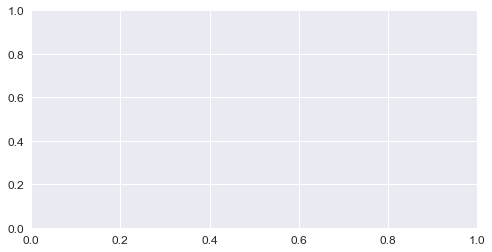

In [309]:
i+=1
train_model(
    model_C, 
    dataset_C, 
    path + name_C,
    learning_rate=1e-4,
    #log_dir="./logs/C/" + "all_" + str(i)
    log_dir="./logs/C/" + name + "_" + "x".join(list(map(str, structure_C))) + "_" + str(i)
)

In [ ]:
error